# Deconvolution example

*This example is based on the code of the [sample](https://github.com/opencv/opencv/blob/master/samples/python/deconvolution.py) from OpenCV repository*

## Theory

More precisely this example shows the usage of [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) to perform Weiner deconvolution of an image with user-defined point spread function ([PSF](https://en.wikipedia.org/wiki/Point_spread_function)). Following [wiki](https://en.wikipedia.org/wiki/Deconvolution): 

> In mathematics, deconvolution is an algorithm-based process used to reverse the effects of convolution on recorded data. 

In case of images, we assume that the recorded image $y$ is obtained from an 'original' $x$ convolved with a kernel $h$ (which represents motion blur, or defocusing) and noise $n$

$$ y = h * x + n $$

[Wikipedia](https://en.wikipedia.org/wiki/Wiener_deconvolution) says : 
> In mathematics, Wiener deconvolution is an application of the Wiener filter to the noise problems inherent in deconvolution. It works in the frequency domain, attempting to minimize the impact of deconvolved noise at frequencies which have a poor signal-to-noise ratio.

The idea is than to an estimate image $\hat x$ such that $\hat x = g * y$ that minimizes the mean square error.

> The Wiener deconvolution filter provides such a $g$. The filter is most easily described in the frequency domain:

> $$ G(f)={\frac {H^{*}(f)S(f)}{|H(f)|^{2}S(f)+N(f)}} $$
or 
$$ G(f) = \frac{1}{H(f)} \left[ \frac{|H(f)|^2}{ |H(f)|^2  +  \frac{1}{SNR(f)} } \right]$$

> Here,   $1/H(f)$ is the inverse of the original system, and   $\mathrm {SNR} (f)=S(f)/N(f)$ is the signal-to-noise ratio. When there is zero noise (i.e. infinite signal-to-noise), the term inside the square brackets equals 1, which means that the Wiener filter is simply the inverse of the system, as we might expect. However, as the noise at certain frequencies increases, the signal-to-noise ratio drops, so the term inside the square brackets also drops. This means that the Wiener filter attenuates frequencies dependent on their signal-to-noise ratio.

Some more interesting examples on deconvolution can be found [here](http://yuzhikov.com/articles/BlurredImagesRestoration1.htm) and [here](http://yuzhikov.com/articles/BlurredImagesRestoration2.htm).


In [1]:
%matplotlib notebook

from math import pi

import numpy as np
import matplotlib.pylab as plt 
import cv2

Load an image with a motion blur

<IPython.core.display.Javascript object>


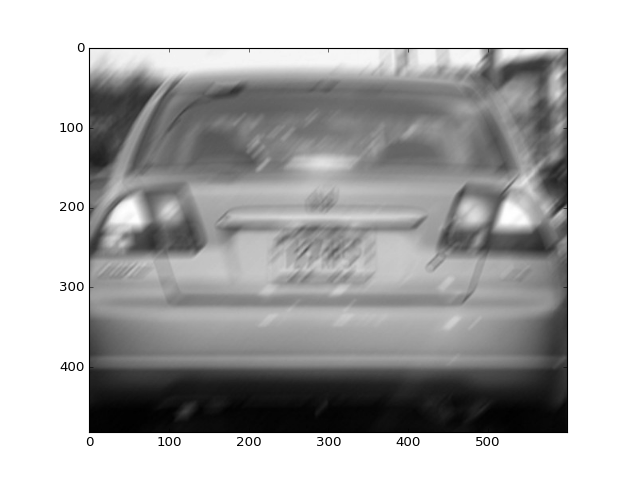

In [2]:
filename = "data/licenseplate_motion.jpg"    
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE )
assert img is not None, "File is not found"

plt.figure()
plt.imshow(img, cmap='gray')

In order to restore this image to the original one we need to define a PSF (it corresponds to $h$ variable from above equations). Let us choose a PSF as a small interval oriented in the direction of the motion blur. 

<IPython.core.display.Javascript object>


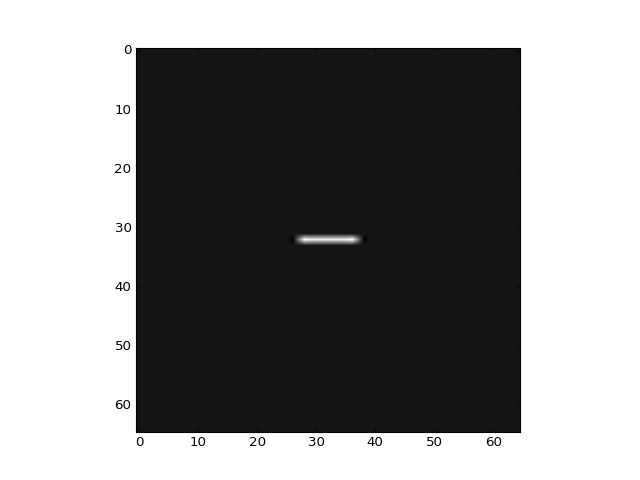

/home/osboxes/Documents/TDS/venv/local/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


<function __main__.interactive_motion_kernel>

In [3]:
from ipywidgets import interact, FloatSlider, IntSlider

def motion_kernel(angle, d, sz=65):
    # Define an interval of length 'd'
    kern = np.ones((1, d), np.float32)
    # Define a 2d rotation matrix (OZ axe fixed)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    # Define a translation part
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    # Apply affine transformation
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    kern /= kern.sum()
    return kern


def interactive_motion_kernel(angle, d):
    plt.figure()
    k = motion_kernel( angle * pi / 180.0, d)
    plt.imshow(k, cmap='gray')
    
interact(interactive_motion_kernel,  
         angle=FloatSlider(min=0, max=90, value=0.0, continuous_update=True),
         d=FloatSlider(min=0.5, max=65, step=1.0, value=10.0, continuous_update=True))

We need to pad computed kernel to the size of the image. Thus, we obtain a PSF and we can compute a DFT of the PSF.

<IPython.core.display.Javascript object>


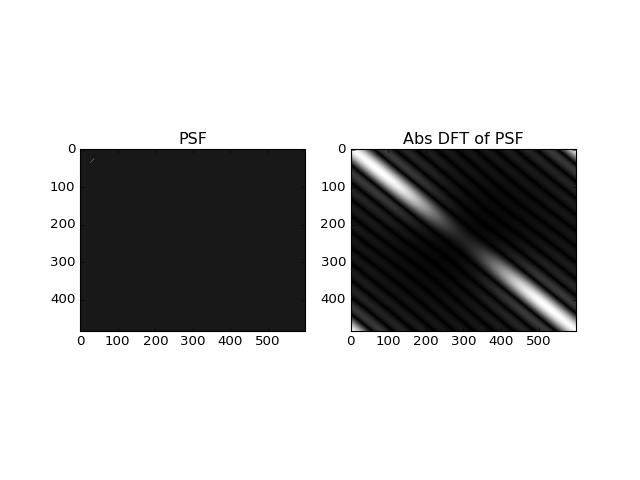

In [4]:
kernel = motion_kernel(135.0 * pi / 180.0, 15.0)
psf_pad = np.zeros_like(img, dtype=np.float32)
kh, kw = kernel.shape
psf_pad[:kh, :kw] = kernel

PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)


plt.figure()
plt.subplot(121)
plt.title("PSF")
plt.imshow(psf_pad, cmap='gray')
plt.subplot(122)
plt.title("Abs DFT of PSF")
plt.imshow(cv2.magnitude(PSF[:,:,0], PSF[:,:,1]), cmap='gray')

Function Signal-Noise Ratio (SNR) is unknown, therefore we approximate it by a constant value. Finally, we can compute Weiner filter $G(f)$ and perform the deconvolution.

In [16]:
SNR = 20

# Compute DFT of the input image
IMG = cv2.dft(img.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
# Compute |PSF|^2
PSF2 = (PSF**2).sum(-1)  
# PSF has shape (h,w,2) and PSF2.shape = (h,w), insert newaxis
iPSF = PSF / ((PSF2 + 1.0/SNR)[...,np.newaxis])
# Multiply 
RES = cv2.mulSpectrums(IMG, iPSF, 0)
res = cv2.idft(RES, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
res = np.roll(res, -kh//2, 0)
res = np.roll(res, -kw//2, 1)

<IPython.core.display.Javascript object>


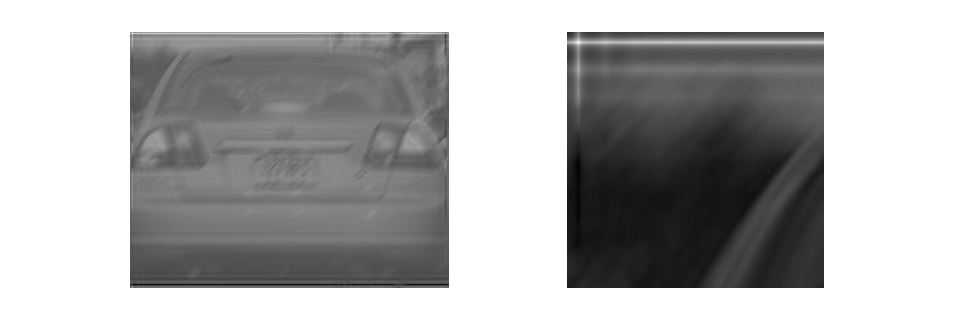

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.axis("off") 
plt.imshow(res, cmap='gray')
plt.subplot(122)
plt.axis("off") 
plt.imshow(res[:100, :100], cmap='gray')

We see that there are some artifacts at boundaries which can be avoided by adding a padding to the input image. Let us take it into account.

<IPython.core.display.Javascript object>


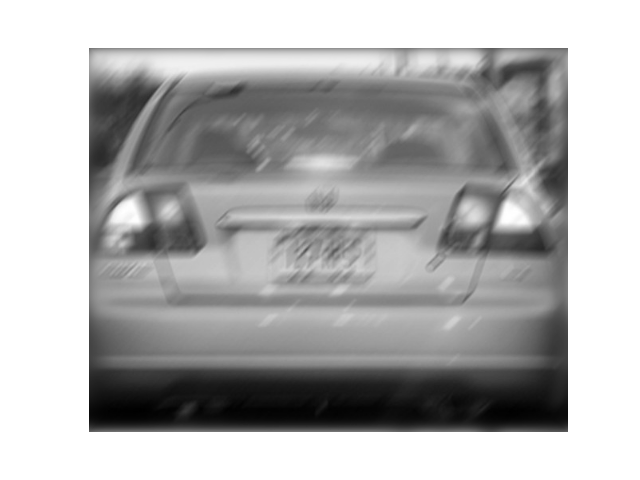

(482, 600) (482, 600)


In [18]:
padding = 31

def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

img_pad = blur_edge(img.astype(np.float32), padding)
plt.figure()
plt.axis("off") 
plt.imshow(img_pad, cmap='gray')
print img.shape, img_pad.shape

<IPython.core.display.Javascript object>


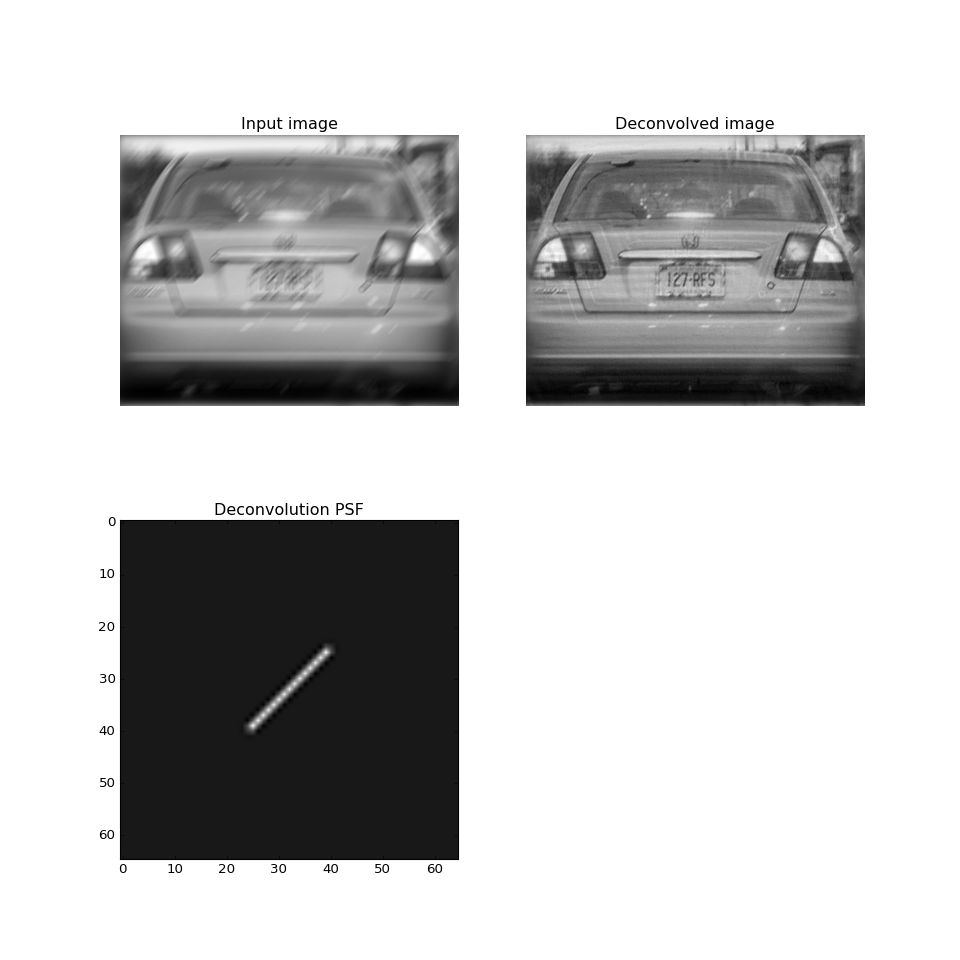

<function __main__.interactive_motion_deconv>

In [20]:
# Compute DFT of the input image
IMG = cv2.dft(img_pad, flags=cv2.DFT_COMPLEX_OUTPUT)


def interactive_motion_deconv(angle_deg, size, snr):

    kernel = motion_kernel(angle_deg * pi / 180.0, size)
    psf_pad = np.zeros_like(img_pad, dtype=np.float32)
    kh, kw = kernel.shape
    psf_pad[:kh, :kw] = kernel
    PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
    # Compute |PSF|^2
    PSF2 = (PSF**2).sum(-1)  
    # PSF has shape (h,w,2) and PSF2.shape = (h,w), insert newaxis
    iPSF = PSF / ((PSF2 + 10.0**(-snr))[...,np.newaxis])
    # Multiply 
    RES = cv2.mulSpectrums(IMG, iPSF, 0)
    res = cv2.idft(RES, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    res = np.roll(res, -kh//2, 0)
    res = np.roll(res, -kw//2, 1)
    
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.axis("off") 
    plt.title("Input image")
    plt.imshow(img_pad, cmap='gray')
    plt.subplot(222)
    plt.axis("off") 
    plt.title("Deconvolved image")
    plt.imshow(res, cmap='gray')
    plt.subplot(223)
    plt.title("Deconvolution PSF")
    plt.imshow(kernel, cmap='gray')
    
interact(interactive_motion_deconv,
        angle_deg=FloatSlider(min=0.0, max=180.0, value=135.0, continuous_update=False),
        size=FloatSlider(min=1.0, max=90.0, value=22.0, continuous_update=False),
        snr=FloatSlider(min=0.01, max=5.0, value=2.0, continuous_update=False))



Next, we can generate blurred images from some test images and try the previous deconvolution procedure

In [21]:
# Method to get PSF
def get_psf(kernel, image_size):
    _psf_pad = np.zeros(image_size, dtype=np.float32)
    _kh, _kw = kernel.shape
    _psf_pad[:kh, :kw] = kernel
    return _psf_pad
    
# Method to compute deconvolution from image and estimated kernel and snr
def deconvolution(img, kernel, snr):
    _img_pad = blur_edge(img.astype(np.float32), padding)
    _IMG = cv2.dft(_img_pad, flags=cv2.DFT_COMPLEX_OUTPUT)
    _psf_pad = get_psf(kernel, _img_pad.shape)
    _kh, _kw = kernel.shape
    _PSF = cv2.dft(_psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = _kh)
    # Compute |PSF|^2
    _PSF2 = (_PSF**2).sum(-1)  
    # PSF has shape (h,w,2) and PSF2.shape = (h,w), insert newaxis
    _iPSF = _PSF / ((_PSF2 + 10.0**(-snr))[...,np.newaxis])
    # Multiply 
    _RES = cv2.mulSpectrums(_IMG, _iPSF, 0)
    _res = cv2.idft(_RES, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    _res = np.roll(_res, -_kh//2, 0)
    _res = np.roll(_res, -_kw//2, 1)
    return _res


In [22]:
# Load some test files
import os 

filenames = ['baboon.jpg', 'IMG_3774.JPG', 'IMG_3775.JPG', 'IMG_3776.JPG']
test_images = []
for filename in filenames:
    p = os.path.join("data", filename)
    if not os.path.isfile(p):
        continue
    i = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    test_images.append(i)

In [23]:
# Generate motion kernels that we use to blur images
kernels = [
    motion_kernel(0.01 * pi / 180.0, 50.0), 
    motion_kernel(12.0 * pi / 180.0, 15.0), 
    motion_kernel(51.0 * pi / 180.0, 35.0), 
    motion_kernel(np.random.random() * 2.0 * pi - pi, 50.0 * np.random.random() + 0.01),
    motion_kernel(np.random.random() * 2.0 * pi - pi, 50.0 * np.random.random() + 0.01)
]

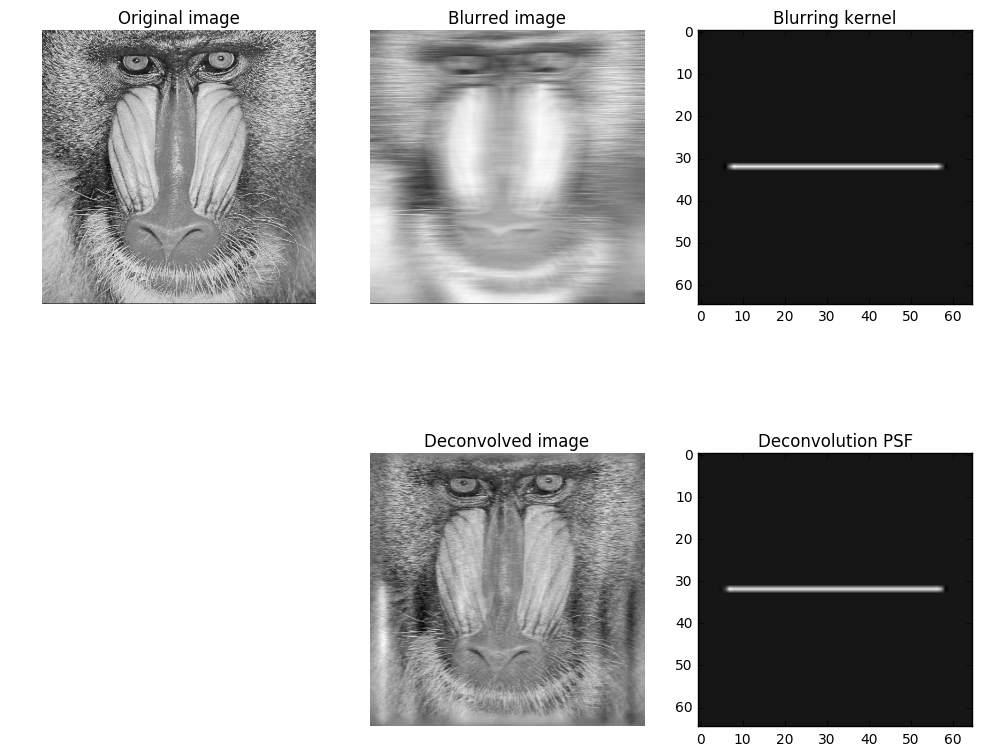

In [24]:
def interactive_motion_deconv(image_index, blur_index, angle_deg, size, snr):
    
    original_img = test_images[image_index]
    blur_kernel = kernels[blur_index]
    blurred_img = cv2.filter2D(original_img, cv2.CV_32F, blur_kernel)
    
    estimated_kernel = motion_kernel(angle_deg * pi / 180.0, size)
    res = deconvolution(blurred_img, estimated_kernel, snr)
        
    plt.figure(figsize=(12,10))
    plt.subplot(231)
    plt.title("Original image")
    plt.axis("off") 
    plt.imshow(original_img, cmap='gray')
    plt.subplot(232)
    plt.title("Blurred image")
    plt.axis("off") 
    plt.imshow(blurred_img, cmap='gray')
    plt.subplot(233)
    plt.title("Blurring kernel")
    plt.imshow(blur_kernel, cmap='gray')
    plt.subplot(236)
    plt.title("Deconvolution PSF")
    plt.imshow(estimated_kernel, cmap='gray')
    plt.subplot(235)
    plt.title("Deconvolved image")
    plt.axis("off") 
    plt.imshow(res, cmap='gray')
    
    
interact(interactive_motion_deconv,
        image_index=IntSlider(min=0, max=len(test_images)-1, value=0, continuous_update=False),
        blur_index=IntSlider(min=0, max=len(kernels)-1, value=0, continuous_update=False),
        angle_deg=FloatSlider(min=0.0, max=180.0, value=135.0, continuous_update=False),
        size=FloatSlider(min=0.0, max=90.0, value=22.0, continuous_update=False),
        snr=FloatSlider(min=0.01, max=5.0, value=2.0, continuous_update=False))

## PSF estimation

In this section we would like to explore how to automatically estimate PSF and perform deconvolution without manually specifying the form of the PSF. This task is called [blind deconvolution](https://en.wikipedia.org/wiki/Blind_deconvolution). 

How we can proceed ? An naive approach would be to define a metric of blurriness and then iteratively minimize this parameter...

There exists such a metric in OpenCV, called [`calcBlurriness`](https://github.com/opencv/opencv/blob/master/modules/videostab/src/deblurring.cpp) in `videostab` module, which estimates edges : 

``` c++
float calcBlurriness(const Mat &frame)
{
    CV_INSTRUMENT_REGION()

    Mat Gx, Gy;
    Sobel(frame, Gx, CV_32F, 1, 0);
    Sobel(frame, Gy, CV_32F, 0, 1);
    double normGx = norm(Gx);
    double normGy = norm(Gy);
    double sumSq = normGx*normGx + normGy*normGy;
    return static_cast<float>(1. / (sumSq / frame.size().area() + 1e-6));
}
```







In [25]:
def calcBlurriness(img):
    h, w = img.shape[:2]
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    ngx = cv2.norm(gx)
    ngy = cv2.norm(gy)
    sumSq = ngx**2 + ngy**2
    return 1.0 / (sumSq /(w*h) + 1e-6)

Now we can compute this metric on test images : original and blurred. 

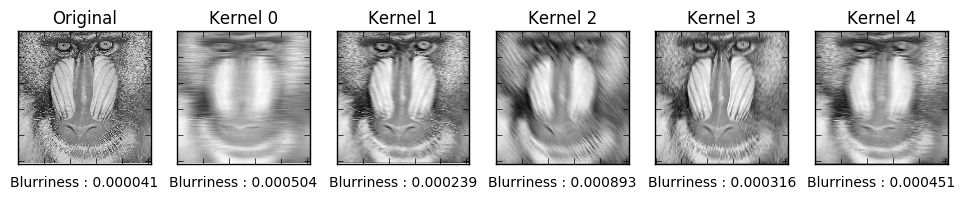

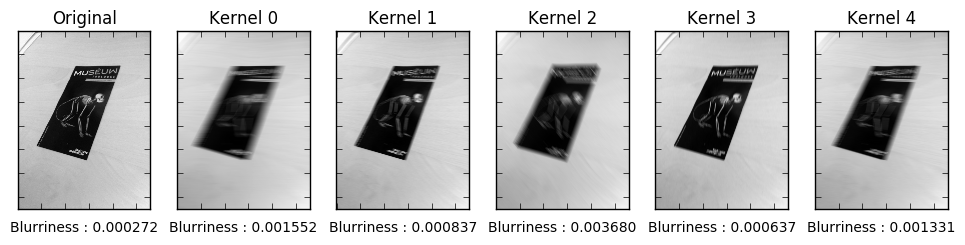

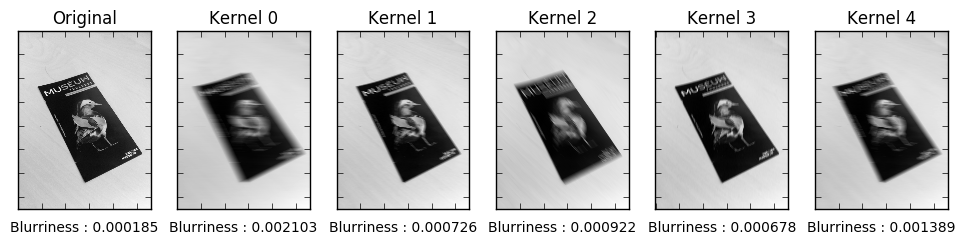

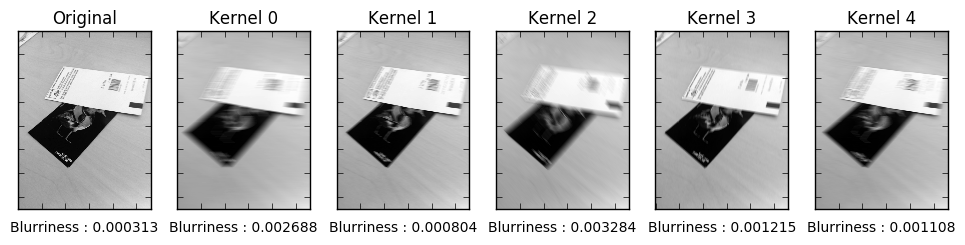

In [40]:
%matplotlib inline
from matplotlib.ticker import NullFormatter

for original_img in test_images:
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(1,len(kernels)+1,1)
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_major_formatter(NullFormatter())

    plt.title("Original")
    plt.imshow(original_img, cmap='gray')
    blurriness = calcBlurriness(original_img)
    
    plt.xlabel("Blurriness : %f" % blurriness)
    
    for index, bk in enumerate(kernels):
        
        blur_kernel = kernels[index]
        blurred_img = cv2.filter2D(original_img, cv2.CV_32F, blur_kernel)
        
        ax = plt.subplot(1,len(kernels)+1,index+2)
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_major_formatter(NullFormatter())

        plt.title("Kernel %i" % index)
        plt.imshow(blurred_img, cmap='gray')
        blurriness = calcBlurriness(blurred_img)
        plt.xlabel("Blurriness : %f" % blurriness)
        
    
        

Indeed, this parameter is minimal for original images and rather large for blurred images. However, if try to minimize manually this parameter for motion blur, we can found out that its minimum does not correspond to an unblurred image. Setup `angle_deg` to 135 and `size` to 22 and change values of `snr` going to its maximum widget value. We can see that blurriness parameter can be very small, but the obtained deconvolved image is not at all what we would like to get.

Input image blurriness :  0.000875526250453
Deconvolved image blurriness :  1.99113122987e-05


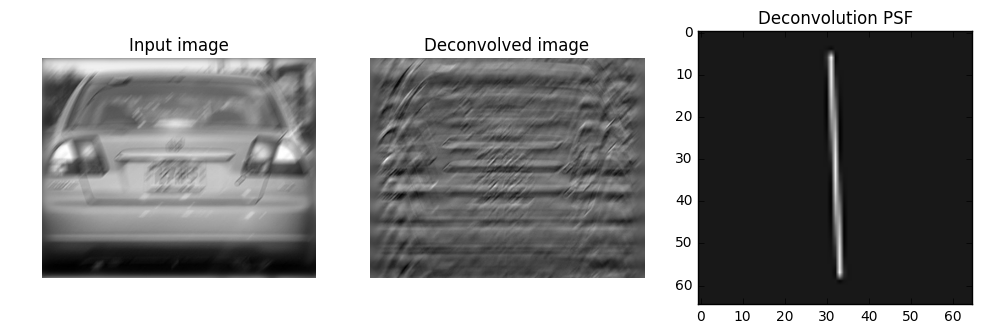

In [45]:
def interactive_motion_deconv(angle_deg, size, snr):

    estimated_kernel = motion_kernel(angle_deg * pi / 180.0, size)
    res = deconvolution(img_pad, estimated_kernel, snr)
    
    plt.figure(figsize=(12,12))
    plt.subplot(131)
    plt.axis("off") 
    plt.title("Input image")
    plt.imshow(img_pad, cmap='gray')
    plt.subplot(132)
    plt.axis("off") 
    plt.title("Deconvolved image")
    plt.imshow(res, cmap='gray')
    plt.subplot(133)
    plt.title("Deconvolution PSF")
    plt.imshow(estimated_kernel, cmap='gray')
    
    print "Input image blurriness : ", calcBlurriness(img)
    print "Deconvolved image blurriness : ", calcBlurriness(res)
    
interact(interactive_motion_deconv,
        angle_deg=FloatSlider(min=0.0, max=180.0, value=0.0, continuous_update=False),
        size=FloatSlider(min=1.0, max=90.0, value=1.0, continuous_update=False),
        snr=FloatSlider(min=0.01, max=5.0, value=1.0, continuous_update=False))



For more information on the subject, see this [article](http://cs.nyu.edu/~fergus/papers/deblur_fergus.pdf) of *Fergus et al*.